#Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from datasets import Dataset
from sklearn.metrics import classification_report, accuracy_score, f1_score
from transformers import AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments,AutoTokenizer, Trainer
import re
from nltk.corpus import stopwords
import spacy

RuntimeError: Failed to import transformers.data.data_collator because of the following error (look up to see its traceback):
module 'tensorflow' has no attribute 'data'

# Loading and Cleaning Sentiment Data

- Link to dataset: https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis

- This dataset consists of 5k+ sequences and 3 classes: positive, negative, neutral
- The amount of data seems sufficient for finetuning a pretrained transformer for sentiment analysis

In [16]:
train_path = "../sentiment_data.csv"
test_path = "../sentiment-topic-test.tsv"
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path, sep='\t')

# function to clean text
def clean_text(sentence, remove_stopwords_and_lemmatize=False):
    # remove digits, punctuations, special chars and extra spaces
    sentence = re.sub(r'[^a-zA-Z! ]+', '', sentence)
    sentence = re.sub(r'\s+', ' ', sentence).strip()
    return sentence

# get cleaned train and test sentences
xtrain = train_data['Sentence'].apply(clean_text)
xtest = test_data['sentence'].apply(clean_text)

# get encoded labels according to hugging face documentation
label_map = {'positive': 2, 'negative': 0, 'neutral': 1}
ytrain = train_data['Sentiment'].map(lambda x: label_map[x])
ytest = test_data['sentiment'].map(lambda x: label_map[x])

# Visualize Train and Test Data Distribution

Instances in training data: 5842. Instances in test data: 18


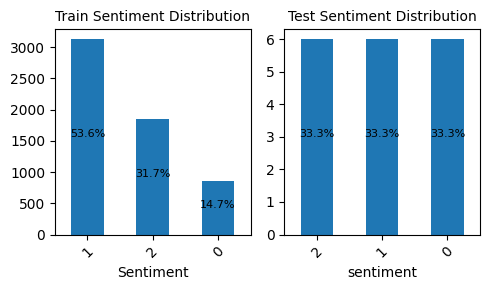

In [17]:
print(f"Instances in training data: {len(xtrain)}. Instances in test data: {len(xtest)}")

# plot the distribution of instances in train and test data
label_counts_test =  ytest.value_counts()
label_counts_train =  ytrain.value_counts()
fig, axes = plt.subplots(1, 2, figsize=(5, 3))

# Train plot
label_counts_train.plot(kind='bar', ax=axes[0])
axes[0].set_title("Train Sentiment Distribution", fontsize=10)
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(label_counts_train):
    pct = f"{(v / label_counts_train.sum()) * 100:.1f}%"
    axes[0].text(i, v * 0.5, pct, ha='center', fontsize=8)

# Test plot
label_counts_test.plot(kind='bar', ax=axes[1])
axes[1].set_title("Test Sentiment Distribution", fontsize=10)
axes[1].tick_params(axis='x', rotation=45)
for i, v in enumerate(label_counts_test):
    pct = f"{(v / label_counts_test.sum()) * 100:.1f}%"
    axes[1].text(i, v * 0.5, pct, ha='center', fontsize=8)

plt.tight_layout()
plt.show()

# Experiment Template

In [28]:
def sentiment_transformer_experiments(
        model_name,
        train_dataset,
        test_dataset,
        data_collator,
        save_path="./sentiment_transformer",
        lr=5e-5,
        num_epochs=5,
        lemmatize_and_remove_stopwords=False
        ):
    # define the model
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Function for evalutaion metrics
    def eval_metrics(eval_pred):
        logits, labels = eval_pred
        preds = logits.argmax(-1)
        acc = accuracy_score(labels, preds)
        macro_f1 = f1_score(labels, preds, average='macro')
        return {"accuracy": acc, "macrof1": macro_f1}

    # define training args and trainer
    training_args1 = TrainingArguments(
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=num_epochs,
        learning_rate=lr,
        eval_strategy="epoch",
        logging_strategy="epoch",
        save_strategy="no",
    )
    trainer = Trainer(
        model=model,
        args=training_args1,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        data_collator=data_collator,
        compute_metrics=eval_metrics
    )
    # trainer.save_model(save_path)

    # train model
    trainer.train()

    # collect metrics to plot
    log_history = trainer.state.log_history
    accs = [log['eval_accuracy'] for log in log_history if 'eval_accuracy' in log]
    macro_f1s = [log['eval_macrof1'] for log in log_history if 'eval_macrof1' in log]

    # plot accuracies and macro f1s
    epochs = range(1, len(accs)+1)
    plt.plot(epochs, accs, label='Accuracy')
    plt.plot(epochs, macro_f1s, label='Macro F1')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    if lemmatize_and_remove_stopwords:
        plt.title(f"With stop words and lemmatization. lr={lr}")
    else:
        plt.title(f"Without stop words and lemmatization. lr={lr}")
    plt.legend()
    plt.show()

    #evaluate model and print classification report
    preds = trainer.predict(test_dataset).predictions.argmax(-1)
    if lemmatize_and_remove_stopwords:
        print(f"With stop words and lemmatization. lr={lr}")
    else:
        print(f"Without stop words and lemmatization. lr={lr}")
    print(classification_report(test_dataset['labels'], preds, digits=3))

NameError: name 'test_dataset' is not defined

In [19]:
# model to use
model_name = "cardiffnlp/twitter-roberta-base-sentiment"

# tokenizer for the pretrained model
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize_fn(examples):
    return tokenizer(examples, truncation=True, padding=True)

# data collator to apply padding batchwise properly
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# get transformer compatible train and test data
def get_transformer_train_test_data(trainX, trainY, testX, testY):
    """ Takes train and test sentences and labels as input and returns train and test data, each consisting of
        integer-encoded sentences, attention masks and labels for input to huggingface transformers.

        return: Dict
    """
    # encode sentences. For each sentence we get its encoded ids and attention mask
    xtrain_encoded = trainX.map(tokenize_fn)
    xtest_encoded = testX.map(tokenize_fn)

    # prepare train and test datasets
    train_dataset = Dataset.from_dict({
        'input_ids': list(xtrain_encoded.apply(lambda x: x['input_ids'])),
        'attention_mask': list(xtrain_encoded.apply(lambda x: x['attention_mask'])),
        'labels': trainY
        })
    test_dataset = Dataset.from_dict({
        'input_ids': list(xtest_encoded.apply(lambda x: x['input_ids'])),
        'attention_mask': list(xtest_encoded.apply(lambda x: x['attention_mask'])),
        'labels': testY
        })
    return train_dataset,


train_transformer, test_transformer = get_transformer_train_test_data(xtrain, ytrain, xtest, ytest)

english_stopwords = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')
def remove_stopwords_and_lemmatize(sentence):
    doc = nlp(sentence)
    sentence = " ".join([token.lemma_ for token in doc if token.text not in english_stopwords])
    return sentence

xtrain_lemmatized = xtrain.apply(remove_stopwords_and_lemmatize)
xtest_lemmatized = xtest.apply(remove_stopwords_and_lemmatize)
train_transformer_lemmatized, test_transformer_lemmatized = get_transformer_train_test_data(xtrain, ytrain, xtest, ytest)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


# Experiment 1: Without stop word removal and lemmatization

##### Experiment 1a. Changes in macro F1 and Accuracy over 5 epochs with learning rate =  5e-5

In [23]:
sentiment_transformer_experiments(model_name, train_transformer, test_transformer, data_collator)

RuntimeError: MPS backend out of memory (MPS allocated: 4.32 GB, other allocations: 2.34 GB, max allowed: 6.80 GB). Tried to allocate 147.26 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

##### Experiment 1b. Changes in macro F1 and Accuracy over 5 epochs with learning rate =  3e-5

Epoch,Training Loss,Validation Loss,Accuracy,Macrof1
1,0.479200,0.807432,0.500000,0.412698
2,0.312900,0.717335,0.666667,0.669109
3,0.230700,0.788342,0.666667,0.679365
4,0.186300,0.984829,0.611111,0.622222
5,0.156600,1.181157,0.611111,0.622222


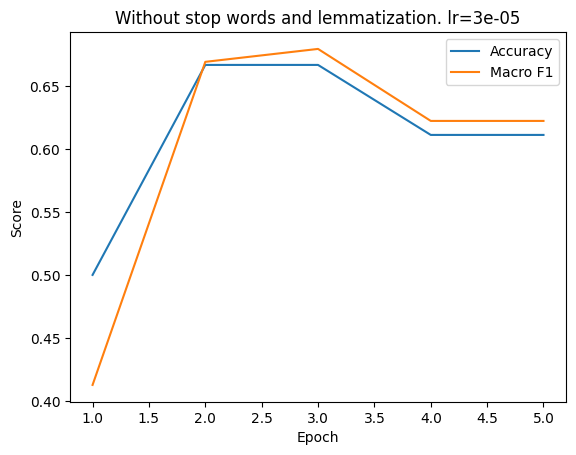

Without stop words and lemmatization. lr=3e-05
              precision    recall  f1-score   support

           0      1.000     0.500     0.667         6
           1      0.444     0.667     0.533         6
           2      0.667     0.667     0.667         6

    accuracy                          0.611        18
   macro avg      0.704     0.611     0.622        18
weighted avg      0.704     0.611     0.622        18



In [56]:
sentiment_transformer_experiments(model_name, train_transformer, test_transformer, data_collator, lr=0.00003)

# Experiment 2: With stop word removal and lemmatization

##### Experiment 2a. Changes in macro F1 and Accuracy over 5 epochs with learning rate =  5e-5

Epoch,Training Loss,Validation Loss,Accuracy,Macrof1
1,0.480500,0.795565,0.611111,0.513557
2,0.310200,0.907899,0.666667,0.669109
3,0.225000,1.017687,0.666667,0.669109
4,0.178300,1.092183,0.722222,0.722222
5,0.151800,1.246464,0.611111,0.600855


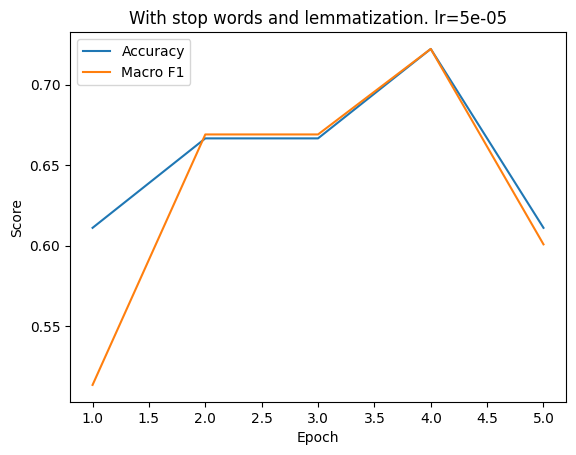

With stop words and lemmatization. lr=5e-05
              precision    recall  f1-score   support

           0      1.000     0.333     0.500         6
           1      0.444     0.667     0.533         6
           2      0.714     0.833     0.769         6

    accuracy                          0.611        18
   macro avg      0.720     0.611     0.601        18
weighted avg      0.720     0.611     0.601        18



In [57]:
sentiment_transformer_experiments(model_name, train_transformer_lemmatized, test_transformer_lemmatized, data_collator, lemmatize_and_remove_stopwords=True)

##### Experiment 2b. Changes in macro F1 and Accuracy over 5 epochs with learning rate =  3e-5

Epoch,Training Loss,Validation Loss,Accuracy,Macrof1
1,0.479200,0.807432,0.500000,0.412698
2,0.312900,0.717335,0.666667,0.669109
3,0.230700,0.788342,0.666667,0.679365
4,0.186300,0.984829,0.611111,0.622222
5,0.156600,1.181157,0.611111,0.622222


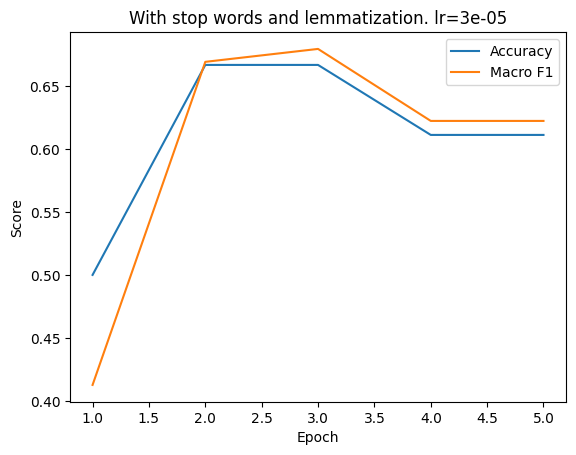

With stop words and lemmatization. lr=3e-05
              precision    recall  f1-score   support

           0      1.000     0.500     0.667         6
           1      0.444     0.667     0.533         6
           2      0.667     0.667     0.667         6

    accuracy                          0.611        18
   macro avg      0.704     0.611     0.622        18
weighted avg      0.704     0.611     0.622        18



In [58]:
sentiment_transformer_experiments(model_name, train_transformer_lemmatized, test_transformer_lemmatized, data_collator, lr=0.00003, lemmatize_and_remove_stopwords=True)